### Imported Important Liabraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import pickle
nltk.download('punkt')
nltk.download('stopwords')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load the Datasets

#### Datasets contain last 10 year tweets of official accounts of India's 3 political parites namely AAP, BJP and INC

In [2]:
df_aap = pd.read_csv('/kaggle/input/indian-political-party-tweets-daily-updated/AamAadmiParty.csv')
df_bjp = pd.read_csv('/kaggle/input/indian-political-party-tweets-daily-updated/BJP4India.csv')
df_inc = pd.read_csv('/kaggle/input/indian-political-party-tweets-daily-updated/INCIndia.csv')

### Preprocessing and Visulisation

In [3]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.replace('\n', ' ')
    text = text.lower()
    text = re.sub(r'\bhttp\w*\b', '', str(text))
    text = text.replace('amp',' ')
    return text

In [4]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text_tokens = text.split()
    filtered_tokens = [token for token in text_tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

In [5]:
def stem_text(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

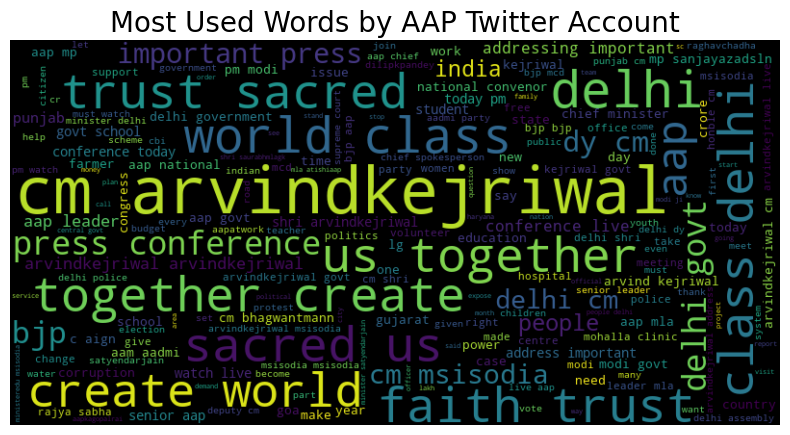

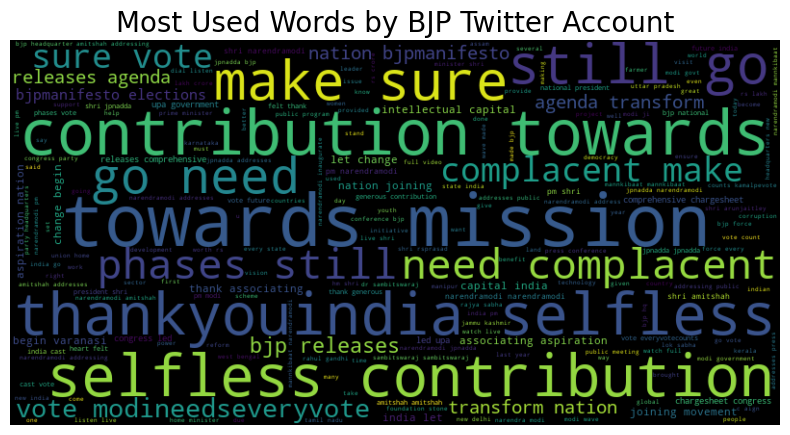

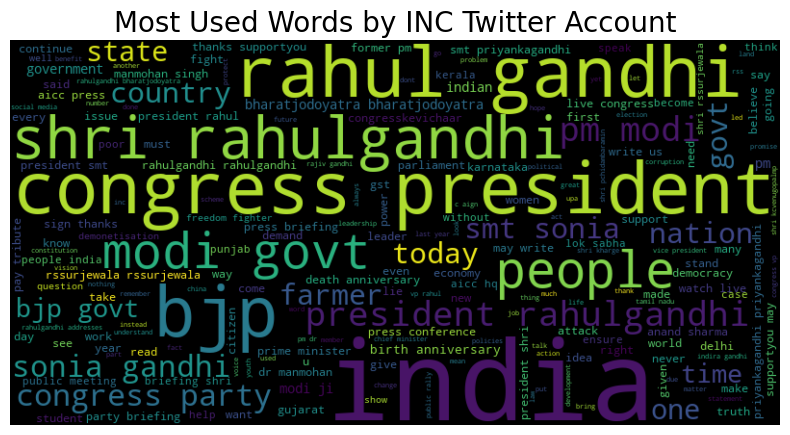

In [6]:
party_names = ['AAP', 'BJP', 'INC']
dfs = [df_aap, df_bjp, df_inc]

for df in dfs:
    df.drop(['Datetime','Tweet Id', 'likeCount'], axis = 1, inplace = True)
    
for party_name, df in zip(party_names, dfs):
    df['Text'] = df['Text'].apply(preprocess_text)
    df['Text'] = df['Text'].apply(remove_stopwords)

    text = ' '.join(df['Text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Used Words by {party_name} Twitter Account', fontsize=20)
    plt.axis('off')
    plt.show()

    df['Text'] = df['Text'].apply(stem_text)

### Concat all Datasets into Single Dataset

In [7]:
df = pd.concat([df_aap, df_bjp, df_inc], axis=0)

df = df.reset_index(drop=True)

In [8]:
df.dropna(inplace = True)

In [9]:
df.head()

,Text,Username
0,manoj tiwari delhi law order lg punjab lgsaxen...,AamAadmiParty
1,,AamAadmiParty
2,delhi bjp june murder cm lg design strength un...,AamAadmiParty
3,power plant import coal domest coal ton import...,AamAadmiParty
4,manojtiwarimp press confer ntpc nptc ga atishiaap,AamAadmiParty


In [10]:
X = df['Text'].values
y = df['Username'].values

In [11]:
X.shape

(397392,)

### Tokenisation and Label Encoding

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [13]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Test Train Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Created and Trained LSTM-RNN Model

In [15]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
9935/9935 [==============================] - 210s 21ms/step - loss: 0.1757 - accuracy: 0.9286 - val_loss: 0.1380 - val_accuracy: 0.9437
Epoch 2/3
9935/9935 [==============================] - 157s 16ms/step - loss: 0.1162 - accuracy: 0.9513 - val_loss: 0.1350 - val_accuracy: 0.9443
Epoch 3/3
9935/9935 [==============================] - 160s 16ms/step - loss: 0.0990 - accuracy: 0.9570 - val_loss: 0.1400 - val_accuracy: 0.9438


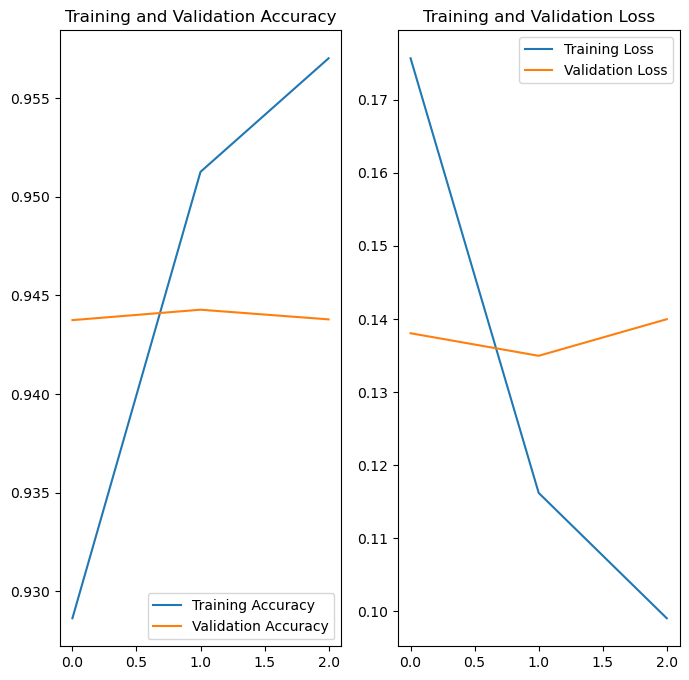

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(3), acc, label='Training Accuracy')
plt.plot(range(3), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(3), loss, label='Training Loss')
plt.plot(range(3), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction Function

In [19]:
def predict_party(tweet):
    processed_text = preprocess_text(tweet)
    text_without_stopwords = remove_stopwords(processed_text)
    stemmed_text = stem_text(text_without_stopwords)
    
    encoded_text = tokenizer.texts_to_sequences([stemmed_text])
    padded_text = pad_sequences(encoded_text, maxlen=X.shape[1])
    
    prediction = model.predict(padded_text)
    predicted_party = label_encoder.inverse_transform([np.argmax(prediction)])
    
    return predicted_party[0]

### Prediction of Username by famous slogans of Political Parties

In [20]:
test_text = ["Bharat Jodo Yatra","Sabka Saath Sabka Vikas","Delhi Schools are Transformed"]
for i in test_text:
    predicted_party = predict_party(i)
    print(f"The predicted party Username for Tweet '{i}' is: {predicted_party}")

1/1 [==============================] - 0s 397ms/step
The predicted party Username for Tweet 'Bharat Jodo Yatra' is: INCIndia
1/1 [==============================] - 0s 20ms/step
The predicted party Username for Tweet 'Sabka Saath Sabka Vikas' is: BJP4India
1/1 [==============================] - 0s 22ms/step
The predicted party Username for Tweet 'Delhi Schools are Transformed' is: AamAadmiParty


### Save the Model

In [21]:
model.save('model.h5')

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)